In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import matplotlib as plt
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from torch.nn import *
import cv2

In [3]:
class CE_DiceLoss(nn.Module):
    def __init__(self):
        super(CE_DiceLoss, self).__init__()

    def forward(self, inp, target):
        inp = torch.sigmoid(inp)
        target = target.type(torch.FloatTensor).cuda()
        CE_val = nn.BCELoss(inp, target)
        dice_val = self.dice_loss(inp, target)
        
        return (CE_val + dice_val)/2
        
    def dice_loss(self, inp, target):
        smooth = 1.
        loss = 0.
        for c in range(n_classes):
            iflat = inp[:, c ].view(-1)
            tflat = target[:, c].view(-1)
            intersection = (iflat * tflat).sum()

            w = class_weights[c]
            loss += w * (1 - ((2. * intersection + smooth)/(iflat.sum() + tflat.sum() + smooth)))
        return loss

In [4]:
path = Path("/home/ubuntu/Kharbanda/Buildings")
path_img = path/'Images'
path_mask = path/'Masks'

In [5]:
all_img = get_image_files(path_img)
fname = [x for x in all_img if str(x.stem[15:29]) == "AOI_5_Khartoum"] 
fname[:5]

[PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_5_Khartoum_img665.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_5_Khartoum_img807.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_5_Khartoum_img1686.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_5_Khartoum_img481.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_5_Khartoum_img1557.tif')]

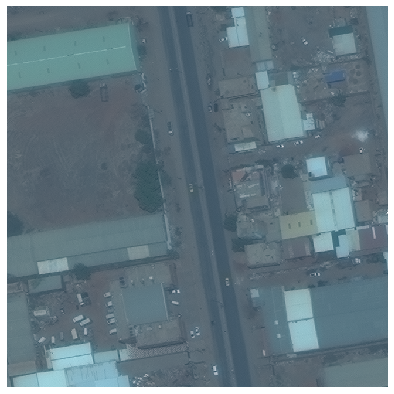

In [9]:
img = open_image(fname[18])
img.show(figsize=(7,7))

In [11]:
# string = 'Images/'
# data = [string + x.name for x in fname]

# v1_df = pd.DataFrame(data, columns = ['Images'])
# v1_df.to_csv("Khartoum_buildings.csv")

In [5]:
khartoum_df = pd.read_csv(path/'Khartoum_buildings.csv')
khartoum_df = khartoum_df.drop(columns = 'Unnamed: 0')
khartoum_df.head()

,Images
0,Images/RGB-PanSharpen_AOI_5_Khartoum_img665.tif
1,Images/RGB-PanSharpen_AOI_5_Khartoum_img807.tif
2,Images/RGB-PanSharpen_AOI_5_Khartoum_img1686.tif
3,Images/RGB-PanSharpen_AOI_5_Khartoum_img481.tif
4,Images/RGB-PanSharpen_AOI_5_Khartoum_img1557.tif


In [6]:
len(khartoum_df)

1012

In [7]:
get_y_fn = lambda x: path_mask/f'{Path(x).name}'

In [8]:
def save_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.save(f'{City}_{Freezed}_{Size}_{Iter}')
    
def load_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.load(f'{City}_{Freezed}_{Size}_{Iter}')

In [9]:
codes = [0,'building']
random.seed(42)
src = (SegmentationItemList.from_df(khartoum_df, path).
      split_by_rand_pct(.10).
      label_from_func(get_y_fn, classes=codes))

In [15]:
bs = 32
size = 224
data = (src.transform(get_transforms(flip_vert = True, max_rotate = 15, max_zoom=1.3, max_lighting = 0.4), size = size, tfm_y=True).
       databunch(bs=bs).normalize(imagenet_stats))

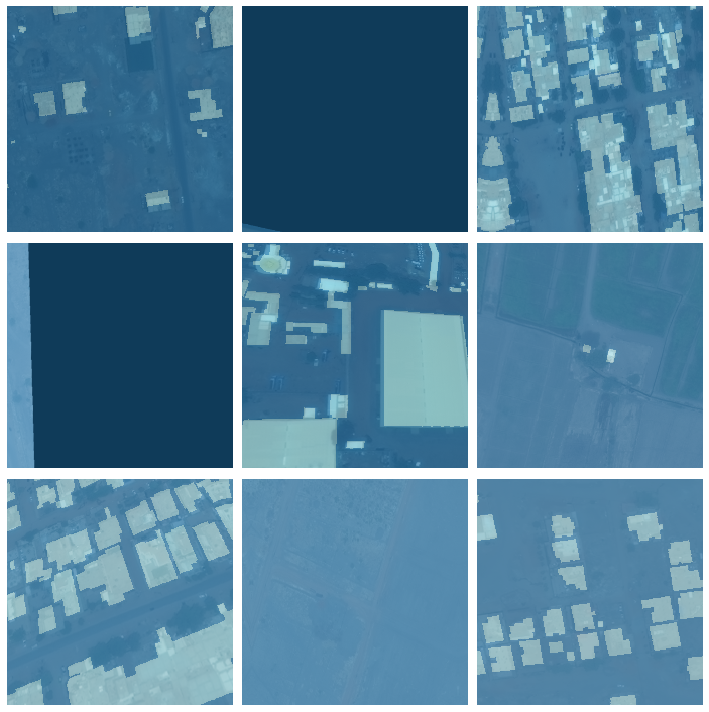

In [16]:
data.show_batch(3, figsize=(10,10))

In [17]:
# wd = 1e-3
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight, 
                     self_attention = True)
learn.loss = CE_DiceLoss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


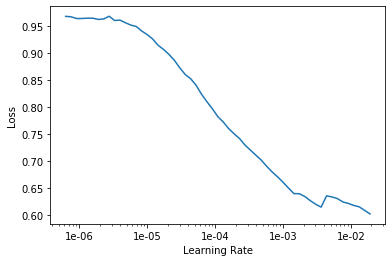

In [18]:
learn.lr_find()
learn.recorder.plot() 

In [19]:
learn.fit_one_cycle(5, slice(5e-4))

epoch,train_loss,valid_loss,dice,time
0,0.505495,0.453262,0.195659,00:16
1,0.381773,0.274597,0.460983,00:15
2,0.312204,0.216062,0.474773,00:15
3,0.266293,0.204545,0.539020,00:15
4,0.242039,0.201801,0.522345,00:15


In [20]:
save_model(learn, 'Khartoum', 'F', 'smol', 1)

# Start Recording

In [10]:
import wandb
from wandb.fastai import WandbCallback

In [22]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                     self_attention = True, callback_fns=partial(WandbCallback, input_type='images'))
learn.loss = CE_DiceLoss

In [23]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Khartoum.ipynb"

In [24]:
wandb.init(project="spacenet_buildings", name = 'Khartoum')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/5fvmm46h

In [25]:
load_model(learn, 'Khartoum', 'F', 'smol', 1)

In [26]:
learn.fit_one_cycle(10, slice(1e-4, 1e-3), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.209035,0.205247,0.560342,00:16
1,0.208389,0.197841,0.569999,00:15
2,0.209001,0.199453,0.573061,00:16
3,0.208353,0.187621,0.555218,00:15
4,0.214145,0.191471,0.582406,00:16
5,0.210920,0.216624,0.569555,00:16
6,0.210021,0.198432,0.593056,00:15
7,0.202321,0.175963,0.609529,00:16
8,0.194062,0.174385,0.578297,00:15
9,0.187917,0.171472,0.604139,00:15


Better model found at epoch 0 with valid_loss value: 0.2052466720342636.
Better model found at epoch 1 with valid_loss value: 0.19784092903137207.
Better model found at epoch 3 with valid_loss value: 0.18762138485908508.
Better model found at epoch 7 with valid_loss value: 0.17596320807933807.
Better model found at epoch 8 with valid_loss value: 0.17438466846942902.
Better model found at epoch 9 with valid_loss value: 0.17147231101989746.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200107_144625-5fvmm46h/bestmodel.pth


In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.173895,0.172234,0.609300,00:16
1,0.175640,0.170581,0.608887,00:16
2,0.175272,0.170282,0.613093,00:16
3,0.174851,0.170551,0.610875,00:16
4,0.174691,0.168488,0.610105,00:16
5,0.174322,0.169143,0.605405,00:16
6,0.175165,0.176290,0.566721,00:16
7,0.175864,0.168514,0.615910,00:16
8,0.174359,0.167034,0.614033,00:16
9,0.172296,0.167938,0.617876,00:16


Better model found at epoch 0 with valid_loss value: 0.17223398387432098.
Better model found at epoch 1 with valid_loss value: 0.1705806404352188.
Better model found at epoch 2 with valid_loss value: 0.17028187215328217.
Better model found at epoch 4 with valid_loss value: 0.16848760843276978.
Better model found at epoch 8 with valid_loss value: 0.1670342981815338.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200107_144625-5fvmm46h/bestmodel.pth


In [30]:
save_model(learn, 'Khartoum', 'UF', 'smol', 2)

In [31]:
learn.fit_one_cycle(10, slice(1e-6, 1e-5), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.168636,0.167020,0.616104,00:16
1,0.168639,0.167515,0.618352,00:16
2,0.169901,0.167660,0.620394,00:16
3,0.169610,0.167041,0.618097,00:16
4,0.170059,0.166829,0.618765,00:16
5,0.169794,0.167054,0.617212,00:16
6,0.169314,0.167012,0.617901,00:16
7,0.170485,0.167249,0.619295,00:16
8,0.169252,0.166957,0.616999,00:16
9,0.169135,0.167511,0.618753,00:16


Better model found at epoch 0 with valid_loss value: 0.16702032089233398.
Better model found at epoch 4 with valid_loss value: 0.16682887077331543.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200107_144625-5fvmm46h/bestmodel.pth


In [32]:
save_model(learn, 'Khartoum', 'UF', 'smol', 3)

## GO BIG

In [11]:
bs = 8
size = 400
data = (src.transform(get_transforms(flip_vert = True, max_rotate = None, max_zoom=1.1, max_lighting = 0.5), size = size, tfm_y=True).
       databunch(bs=bs).normalize(imagenet_stats))

In [12]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                     self_attention = True, callback_fns=partial(WandbCallback, input_type='images'))
learn.loss = CE_DiceLoss

In [13]:
load_model(learn, 'Khartoum', 'UF', 'smol', 2)

In [14]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Khartoum.ipynb"

In [15]:
wandb.init(project="spacenet_buildings", name = 'Khartoum_Big_SA')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/j0nv587w

In [16]:
learn.fit_one_cycle(10, slice(5e-5, 5e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.179398,0.157172,0.612838,00:54
1,0.179645,0.158616,0.588346,00:43
2,0.182429,0.159968,0.620224,00:43
3,0.183429,0.156031,0.610461,00:43
4,0.180234,0.154903,0.621109,00:43
5,0.180124,0.154914,0.615640,00:43
6,0.168095,0.153445,0.618083,00:43
7,0.168288,0.150417,0.621692,00:43
8,0.160458,0.156939,0.642681,00:43
9,0.154482,0.146429,0.637322,00:43


Better model found at epoch 0 with valid_loss value: 0.15717193484306335.
Better model found at epoch 3 with valid_loss value: 0.15603120625019073.
Better model found at epoch 4 with valid_loss value: 0.15490269660949707.
Better model found at epoch 6 with valid_loss value: 0.15344451367855072.
Better model found at epoch 7 with valid_loss value: 0.15041689574718475.
Better model found at epoch 9 with valid_loss value: 0.14642935991287231.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200107_151555-j0nv587w/bestmodel.pth


In [17]:
save_model(learn, 'Khartoum', 'F', 'big', 1)

In [18]:
learn.unfreeze()

In [19]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.152792,0.145684,0.638259,00:44
1,0.150696,0.147851,0.646942,00:44
2,0.153157,0.144606,0.636057,00:44
3,0.154329,0.143449,0.645281,00:44
4,0.155574,0.145975,0.631488,00:45
5,0.155849,0.148018,0.646382,00:44
6,0.154537,0.141602,0.643493,00:44
7,0.153064,0.142111,0.646939,00:44
8,0.150947,0.142864,0.648248,00:44
9,0.146102,0.143028,0.649209,00:44


Better model found at epoch 0 with valid_loss value: 0.1456843614578247.
Better model found at epoch 2 with valid_loss value: 0.1446058750152588.
Better model found at epoch 3 with valid_loss value: 0.1434486359357834.
Better model found at epoch 6 with valid_loss value: 0.14160233736038208.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200107_151555-j0nv587w/bestmodel.pth


In [20]:
save_model(learn, 'Khartoum', 'UF', 'big', 1)

In [21]:
learn.fit_one_cycle(10, slice(1e-6, 5e-5), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.144220,0.143339,0.646580,00:44
1,0.142339,0.143371,0.642625,00:44
2,0.140185,0.143152,0.646876,00:44
3,0.146027,0.143463,0.651068,00:44
4,0.146926,0.143427,0.649534,00:44
5,0.143584,0.141286,0.649797,00:44
6,0.145995,0.141160,0.641762,00:44
7,0.144777,0.141544,0.646793,00:44
8,0.144852,0.140333,0.649661,00:44
9,0.142847,0.141267,0.649412,00:44


Better model found at epoch 0 with valid_loss value: 0.1433388888835907.
Better model found at epoch 5 with valid_loss value: 0.14128582179546356.
Better model found at epoch 6 with valid_loss value: 0.1411595195531845.
Better model found at epoch 8 with valid_loss value: 0.14033296704292297.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200107_151555-j0nv587w/bestmodel.pth


In [23]:
save_model(learn, 'Khartoum', 'UF', 'big', 2)

In [24]:
learn.fit_one_cycle(10, slice(5e-7, 5e-5), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.147415,0.140567,0.651067,00:44
1,0.144206,0.140481,0.651393,00:45
2,0.141875,0.141245,0.647542,00:44
3,0.141740,0.140779,0.657543,00:45
4,0.140249,0.141511,0.651367,00:45
5,0.141161,0.139705,0.654111,00:44
6,0.144225,0.139605,0.655512,00:44
7,0.141968,0.139873,0.651662,00:44
8,0.141280,0.140607,0.657033,00:44
9,0.143002,0.139847,0.654025,00:45


Better model found at epoch 0 with valid_loss value: 0.14056719839572906.
Better model found at epoch 1 with valid_loss value: 0.14048071205615997.
Better model found at epoch 5 with valid_loss value: 0.1397048532962799.
Better model found at epoch 6 with valid_loss value: 0.13960541784763336.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200107_151555-j0nv587w/bestmodel.pth


In [25]:
save_model(learn, 'Khartoum', 'UF', 'big', 3)

In [26]:
learn.fit_one_cycle(10, slice(1e-7, 1e-6), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.144650,0.139364,0.656520,00:44
1,0.140565,0.139520,0.655620,00:44
2,0.139931,0.139518,0.655874,00:44
3,0.142661,0.140006,0.654835,00:45
4,0.142174,0.140341,0.654509,00:44
5,0.142338,0.140293,0.652539,00:44
6,0.142777,0.139838,0.654016,00:44
7,0.144125,0.139255,0.654764,00:44
8,0.141521,0.139777,0.653743,00:44
9,0.140009,0.139932,0.654741,00:45


Better model found at epoch 0 with valid_loss value: 0.1393640786409378.
Better model found at epoch 7 with valid_loss value: 0.13925516605377197.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200107_151555-j0nv587w/bestmodel.pth


In [27]:
save_model(learn, 'Khartoum', 'UF', 'big', 4)